# Carga de librarias

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px 

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix, accuracy_score

from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Bidirectional, Lambda
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [18]:
# Plot del training loss i l'accuracy
def plot_prediction(n_epochs, mfit):
    # TODO
    #Plots 
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

    # plot accuracy during training
    ax[0].set_title('Mse')
    ax[0].plot(mfit.history['mse'], label='train')
    ax[0].plot(mfit.history['val_mse'], label='test')
    ax[0].legend()
    # plot loss during training
    ax[1].set_title('Loss')
    ax[1].plot(mfit.history['loss'], label='train')
    ax[1].plot(mfit.history['val_loss'], label='test')
    ax[1].legend()

def cut_cycles(df, lookback, future, column_features, column_label):
    df_feature = df[column_features]
    df_rul = df[column_label][lookback-1:]

    # Convertimos el dataframe en un numpy array
    numpy_features = df_feature.to_numpy()
    labels = df_rul.to_numpy()
    
    # Creación de listas vacías auxiliares
    features_set = [] 
   
    for i in range(lookback, df.shape[0] - future + 1):
        features_set.append(numpy_features[i - lookback:i]) 

    # Redimensionamiento numpy arrays
    features = np.array(features_set)
    features = np.reshape(features, (features.shape[0], features.shape[1], len(column_features) ))

    return features, labels

def modelo_lstm(input_shape, optimizer):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=30, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    return model

---
# Carga de datos

In [3]:
DATA_DIR = "C:/Users/NetRunner/OneDrive/UOC/Semestre 6/TFM/MultipleDatasets"

train_data = pd.read_csv(f"{DATA_DIR}/train_data.csv")
test_data = pd.read_csv(f"{DATA_DIR}/test_data.csv")

# X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
# y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")
# X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
# y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

In [4]:
data = pd.concat([train_data, test_data])
features = ['volt','rotate','pressure','vibration','error1','error2','error3','error4','error5', 
            'volt_3h_mean', 'rotate_3h_mean', 'pressure_3h_mean', 'vibration_3h_mean', 'volt_24h_mean',
            'rotate_24h_mean', 'pressure_24h_mean', 'vibration_24h_mean', 'error1_count', 'error2_count', 
            'error3_count', 'error4_count', 'error5_count']
label = ['RUL']

print(len(train_data))
print(len(test_data))
print(len(data))

17280
3600
20880


In [5]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
label_scaler = MinMaxScaler(feature_range=(0,1))

feature_scaler.fit(data[features])
label_scaler.fit(data[label].values.reshape(-1,1))

MinMaxScaler()

In [6]:
data_norm = data[features+label].copy()
data_norm[features] = feature_scaler.transform(data[features])
data_norm[label] = label_scaler.transform(data[label].values.reshape(-1,1))
data_norm

,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5,volt_3h_mean,...,volt_24h_mean,rotate_24h_mean,pressure_24h_mean,vibration_24h_mean,error1_count,error2_count,error3_count,error4_count,error5_count,RUL
0,0.384246,0.635590,0.287496,0.550316,0.0,0.0,0.0,0.0,0.0,0.319571,...,0.370829,0.428252,0.398337,0.219217,0.571429,0.500000,0.0,0.333333,0.333333,1.000000
1,0.196252,0.595322,0.298321,0.255010,0.0,0.0,0.0,0.0,0.0,0.214811,...,0.341286,0.432249,0.388561,0.202982,0.571429,0.500000,0.0,0.333333,0.333333,0.998609
2,0.395865,0.468667,0.396966,0.388182,0.0,0.0,0.0,0.0,0.0,0.188577,...,0.332091,0.419061,0.387892,0.197786,0.571429,0.500000,0.0,0.333333,0.333333,0.997218
3,0.487156,0.700909,0.545746,0.547169,0.0,0.0,0.0,0.0,0.0,0.235855,...,0.322535,0.439945,0.394677,0.210147,0.571429,0.500000,0.0,0.333333,0.333333,0.995828
4,0.479313,0.592491,0.348040,0.421442,0.0,0.0,0.0,0.0,0.0,0.365896,...,0.326367,0.442053,0.381300,0.209606,0.571429,0.500000,0.0,0.333333,0.333333,0.994437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,0.590798,0.456078,0.351645,0.786720,0.0,0.0,0.0,0.0,0.0,0.383354,...,0.375683,0.383491,0.336237,0.590127,0.285714,0.166667,1.0,0.333333,0.333333,0.005563
3596,0.455103,0.375885,0.410713,0.749031,0.0,0.0,0.0,0.0,0.0,0.414840,...,0.372778,0.371331,0.324721,0.606392,0.285714,0.166667,1.0,0.333333,0.333333,0.004172
3597,0.509347,0.491140,0.574390,0.500942,0.0,0.0,0.0,0.0,0.0,0.454524,...,0.366536,0.368975,0.338596,0.592431,0.285714,0.166667,1.0,0.333333,0.333333,0.002782
3598,0.638858,0.573666,0.258521,0.588043,0.0,0.0,0.0,0.0,0.0,0.476603,...,0.381726,0.371157,0.324438,0.589367,0.285714,0.166667,1.0,0.333333,0.333333,0.001391


In [7]:
train_norm = data_norm[:len(train_data)]
test_norm = data_norm[len(train_data):(len(train_data)+len(test_data))]

X_train = train_norm.loc[:, train_norm.columns != 'RUL']
y_train = train_norm.loc[:, train_norm.columns == 'RUL']
X_test = test_norm.loc[:, test_norm.columns != 'RUL']
y_test = test_norm.loc[:, test_norm.columns == 'RUL']

---
# Modelo LSTM

In [8]:
rangos = 72

train_3d = cut_cycles(train_norm, rangos, 0, features, label)

X_train_3d = train_3d[0]
y_train_3d = train_3d[1]


test_3d = cut_cycles(test_norm, rangos, 0, features, label)

X_test_3d = test_3d[0]
y_test_3d = test_3d[1]

print('X_train_3d:\t', X_train_3d.shape)
print('y_train_3d:\t', y_train_3d.shape)
print('X_test_3d:\t', X_test_3d.shape)
print('y_test_3d:\t', y_test_3d.shape)

X_train_3d:	 (17209, 72, 22)
y_train_3d:	 (17209, 1)
X_test_3d:	 (3529, 72, 22)
y_test_3d:	 (3529, 1)


In [11]:
%%time
epochs = [100]
batches = [8, 16]
optimizers = ['adam', 'rmsprop']
lrs = [0.01, 0.001, 0.0001] 
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

for epoch in epochs:
    for batch in batches:
        for opt in optimizers:
            for lr in lrs:
                if opt == 'adam':
                    optimizer = Adam(learning_rate=lr)
                elif opt == 'rmsprop':
                    optimizer = RMSprop(learning_rate=lr)
                
                model = modelo_lstm(input_shape, optimizer)
                
                print('=========Training model==========')

                print('Hiperparámetros:')
                print('Optimizer:\t', opt)
                print('Learning Rate:\t', lr)
                print('Epochs:\t\t', epoch)
                print('Batch:\t\t', batch)
                
                res_m = model.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=epoch, batch_size=batch, verbose = 0, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)])
                
                pred = model.predict(X_test_3d)
                pred
                pred_list = [x[0] for x in pred]



                print('\nEvaluation:')
                print('R^2 score:\t\t', r2_score(y_test_3d, pred_list))
                print('MSE score:\t\t', mean_squared_error(y_test_3d, pred_list))
                print('MAE score:\t\t', mean_absolute_error(y_test_3d, pred_list))
                
                print('=================================\n')

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.01
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
111/111 [==============================] - 2s 13ms/step

Evaluation:
R^2 score:		 0.45022060900476635
MSE score:		 0.044559361514754245
MAE score:		 0.16651966790417883

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping
111/111 [==============================] - 2s 13ms/step

Evaluation:
R^2 score:		 0.5060367010255538
MSE score:		 0.04003549346252924
MAE score:		 0.1536788379250833

=========Training model==========
Hiperparámetros:
Optimizer:	 adam
Learning Rate:	 0.0001
Epochs:		 100
Batch:		 8
Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
111/111 [==============================] - 2s 14ms/step

Evaluatio

In [22]:
epochs = 100
optimizer = Adam(learning_rate=0.001)
input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])

model = modelo_lstm(input_shape, optimizer)

res_m = model.fit(X_train_3d, y_train_3d, validation_data=(X_test_3d, y_test_3d), epochs=epochs, batch_size=8, verbose = 1, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', restore_best_weights=True)])


Epoch 1/100
2152/2152 [==============================] - 69s 31ms/step - loss: 0.0689 - mse: 0.0689 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 2/100
2152/2152 [==============================] - 66s 31ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 3/100
2152/2152 [==============================] - 67s 31ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 4/100
2152/2152 [==============================] - 67s 31ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 5/100
2152/2152 [==============================] - 67s 31ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 6/100
2152/2152 [==============================] - 68s 32ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 7/100
2152/2152 [==============================] - 67s 31ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 8/100
2152/2152 [==================

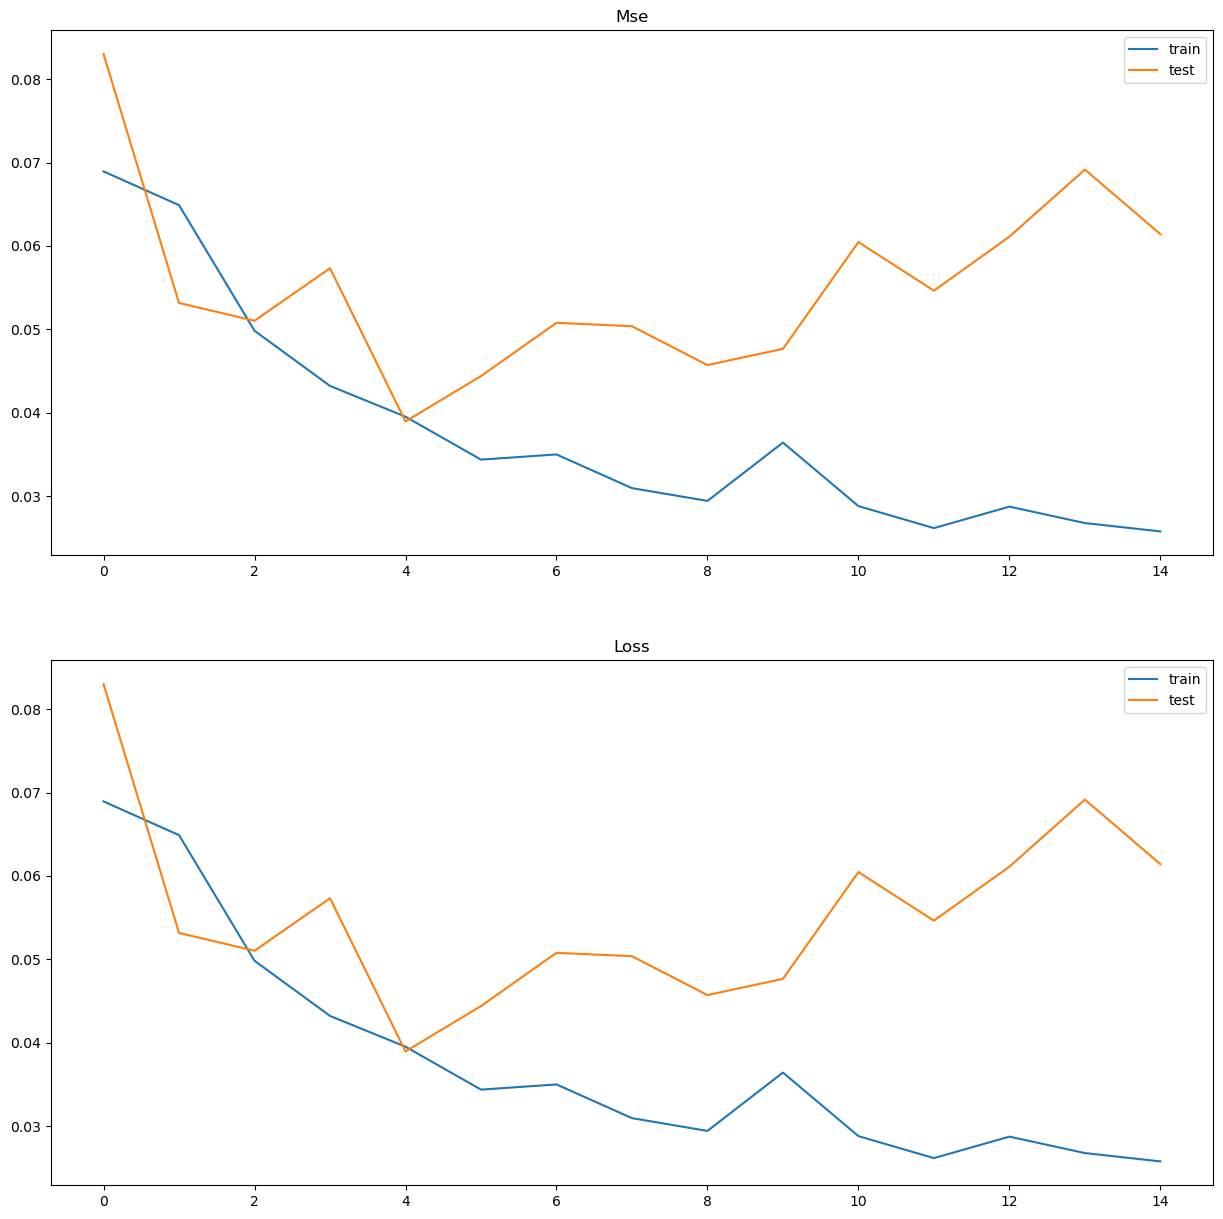

In [23]:
plot_prediction(epochs, res_m)

23/23 [==============================] - 1s 16ms/step


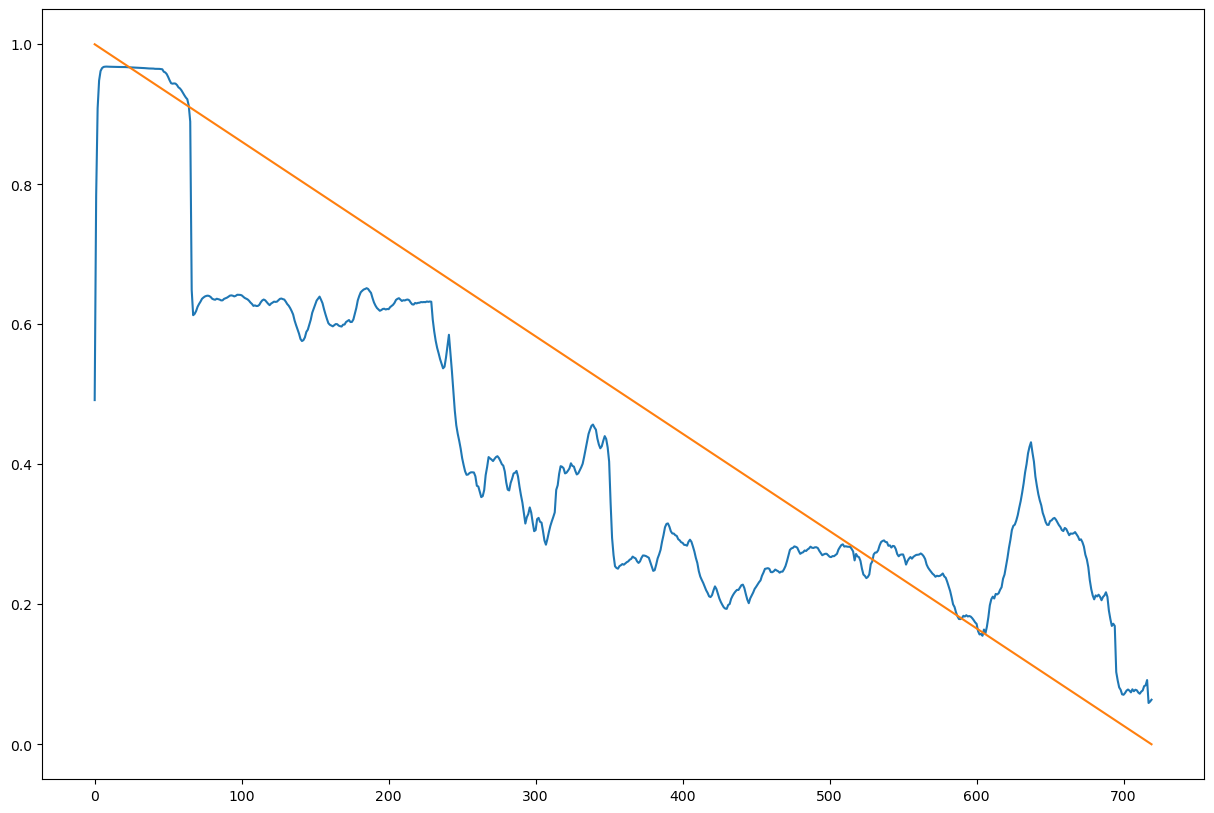

In [24]:
y_test_3d_5 = y_test_3d[(1*720)-rangos+1:(2*720)-rangos+1]
pred = model.predict(X_test_3d[(1*720)-rangos+1:(2*720)-rangos+1])
temp_list = []
for i in range(pred.shape[0]):
    temp_list.append(pred[i])

    
plt.figure(figsize=(15, 10))
plt.plot(temp_list, label='Prediction')
plt.plot(y_test_3d_5, label='Test')
plt.legend(loc='upper right')
plt.yticks([0, 1], ['Normal', 'Warning'])
plt.xlabel('Sample')
plt.ylabel('State')
plt.show()

111/111 [==============================] - 2s 15ms/step


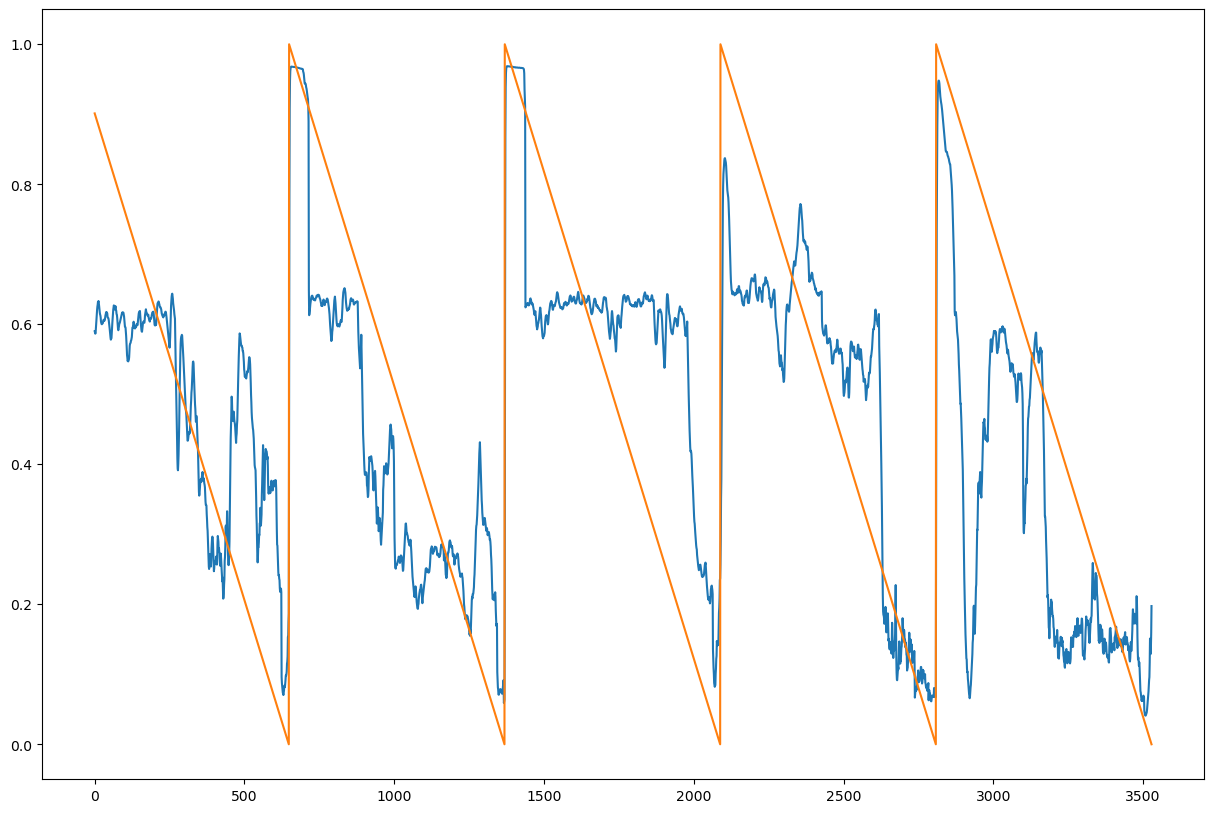

In [25]:
y_test_3d_5 = y_test_3d
pred = model.predict(X_test_3d)
temp_list = []
for i in range(pred.shape[0]):
    temp_list.append(pred[i])

    
plt.figure(figsize=(15, 10))
plt.plot(temp_list)
plt.plot(y_test_3d_5)
plt.show()